In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/home/luca/GitRepositories/Brancher')

import chainer
import chainer.functions as F
import matplotlib.pyplot as plt
import numpy as np

from brancher.distributions import NormalDistribution, LogNormalDistribution
from brancher.variables import DeterministicVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable
from brancher import inference
import brancher.functions as BF

In [15]:
# Normal model
nu = LogNormalVariable(0., 1., "nu")
mu = NormalVariable(0., 10., "mu")
x = NormalVariable(mu, nu, "x")
model = ProbabilisticModel([x,mu,nu])

model.model_summary

,nu_mu,mu_mu,mu,nu_sigma,mu_sigma,x,nu
Distribution,Deterministic,Deterministic,Normal,Deterministic,Deterministic,Normal,Log Normal
Parents,(),(),"{mu_sigma, mu_mu}",(),(),"{nu, mu}","{nu_sigma, nu_mu}"
Observed,False,False,False,False,False,False,False


In [4]:
# Print samples
sample = model.get_sample(10)
sample

,nu_sigma,nu_mu,nu,mu_mu,mu_sigma,mu,x
0,0.541325,0.0,1.741478,0.0,9.999954,1.828647,0.617654
1,0.541325,0.0,0.130888,0.0,9.999954,-6.602525,-6.482183
2,0.541325,0.0,0.783216,0.0,9.999954,11.349712,12.072190
3,0.541325,0.0,1.003168,0.0,9.999954,-5.842826,-7.949784
4,0.541325,0.0,1.684826,0.0,9.999954,3.384259,3.809723
5,0.541325,0.0,0.372555,0.0,9.999954,-4.853252,-4.622584
6,0.541325,0.0,4.152762,0.0,9.999954,5.037520,0.627643
7,0.541325,0.0,0.480123,0.0,9.999954,2.869407,3.189812
8,0.541325,0.0,1.625798,0.0,9.999954,10.224331,10.151538
9,0.541325,0.0,0.649062,0.0,9.999954,7.010172,5.915095


In [5]:
# Print samples from single variable
x_sample = x.get_sample(10)
x_sample

,x
0,5.341552
1,24.809338
2,12.645895
3,-7.912210
4,-15.602011
5,-21.102774
6,14.270484
7,22.740541
8,0.921653
9,1.881742


In [6]:
# Print samples conditional on an input
in_sample = model.get_sample(10, input_values={mu: 100.})
in_sample

,nu_sigma,nu_mu,nu,mu,x
0,0.541325,0.0,1.383634,100.0,98.199043
1,0.541325,0.0,1.068839,100.0,101.090042
2,0.541325,0.0,0.423771,100.0,100.434517
3,0.541325,0.0,4.196307,100.0,104.841759
4,0.541325,0.0,2.641731,100.0,96.343735
5,0.541325,0.0,1.018105,100.0,98.614677
6,0.541325,0.0,1.312255,100.0,100.250359
7,0.541325,0.0,0.251487,100.0,99.689308
8,0.541325,0.0,1.087958,100.0,99.851318
9,0.541325,0.0,3.264057,100.0,100.574898


In [20]:
# # Generate data
nu_real = 1.
mu_real = -2.
data = x.get_sample(number_samples=50, input_values={mu: mu_real, nu:nu_real})

# Observe data
x.observe(data)
model.model_summary

,nu_mu,mu_mu,mu,nu_sigma,mu_sigma,x,nu
Distribution,Deterministic,Deterministic,Normal,Deterministic,Deterministic,Normal,Log Normal
Parents,(),(),"{mu_sigma, mu_mu}",(),(),"{nu, mu}","{nu_sigma, nu_mu}"
Observed,False,False,False,False,False,True,False


In [21]:
# Variational model
Qnu = LogNormalVariable(0., 1., "nu", learnable=True)
Qmu = NormalVariable(0., 1., "mu", learnable=True)
model.set_posterior_model(ProbabilisticModel([Qmu, Qnu]))

# Inference
inference.stochastic_variational_inference(model,
                                           number_iterations=100,
                                           number_samples=50,
                                           optimizer=chainer.optimizers.Adam(0.1))
loss_list = model.diagnostics["loss curve"]

100%|██████████| 100/100 [00:01<00:00, 54.58it/s]


In [24]:
# print posterior sample
post_sample = model.get_posterior_sample(1000)
post_sample.describe()

,nu,mu,x,mu_mu,mu_sigma,nu_mu,nu_sigma
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.412415,-2.001802,-2.048695,-2.010524,-1.127852,0.297099,-0.979924
std,0.475620,0.292543,1.536182,0.000000,0.000000,0.000000,0.000000
min,0.525729,-2.951448,-10.123508,-2.010524,-1.127852,0.297099,-0.979924
25%,1.086713,-2.197143,-2.982007,-2.010524,-1.127852,0.297099,-0.979924
50%,1.328407,-1.993602,-2.012470,-2.010524,-1.127852,0.297099,-0.979924
75%,1.668567,-1.801341,-1.129949,-2.010524,-1.127852,0.297099,-0.979924
max,4.269998,-0.958921,5.953189,-2.010524,-1.127852,0.297099,-0.979924


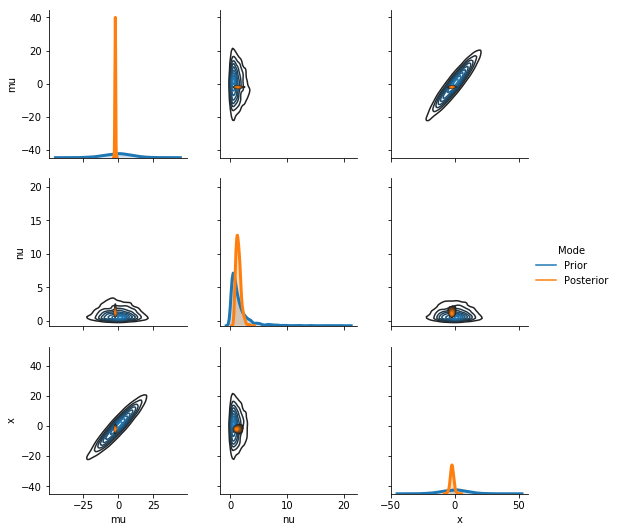

In [26]:
from brancher.visualizations import plot_posterior

plot_posterior(model, variables=["mu", "nu", "x"])